# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary classifier.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title, and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use a random forest classifier, as well as another classifier of your choice; either logistic regression, SVM, or KNN. 

- **Question**: Why would we want this to be a classification problem?
- **Answer**: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)
The URL here has many query parameters
- q for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- l for a location
- start for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
from bs4 import BeautifulSoup

import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from nltk.corpus import stopwords

# import the EDA functions I've built in a Python script
from eda import *

%matplotlib inline

In [3]:
# increase the number of characters shown for each column
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', None)

In [4]:
html = requests.get(URL)

# make sure the response status is ok
assert html.status_code == requests.codes.ok
soup = BeautifulSoup(html.text, 'lxml')

## Write 4 functions to extract these items (one function for each): location, company, job title, and salary.
Example
```python
def extract_location_from_result(result):
    return result.find ...
```

##### - Make sure these functions are robust and can handle cases where the data/field may not be available.
>- Remember to check if a field is empty or None for attempting to call methods on it
>- Remember to use try/except if you anticipate errors.

- **Test** the functions on the results above and simple examples

In [5]:
# first extract all the div's in the 'result' class
def extract_results(soup):
    return soup.find_all('div', class_='result')


# the following functions extract the specified information from *one* result div
# return the specified information, or, if error is encountered, return None 
def extract_location(result):
    """extract job location"""
    try:
        location = result.find('span', class_='location').get_text().strip()
        return location
    except:
        return None


def extract_company(result):
    """extract the name of the company"""
    try:
        company = result.find('span', class_='company').get_text().strip()
        return company
    except:
        return None


def extract_title(result):
    """extract the job title"""
    try:
        title = result.find('a', attrs={'data-tn-element': "jobTitle"}).get('title')
        return title
    except:
        return None


def extract_salary(result):
    """extract the salary"""
    try:
        salary = result.find('td', class_='snip').find('span', class_='no-wrap').get_text().strip()
        return salary
    except:
        return None


# the following functions extract additional information I want to collect
def extract_description(result):
    """extract job description snippet"""
    try:
        description = result.find('span', class_='summary').get_text().strip()
        return description
    except:
        return None


def extract_review(result):
    """extract the number of reviews for the company"""
    try:
        review = result.find('a', attrs={'data-tn-element': "reviewStars"})
        review = review.find('span', class_="slNoUnderline")
        review = review.get_text().strip()
        # extract only the number
        review = review.replace(',', '').replace(' reviews', '')
        return review
    except:
        return None
    
    
def extract_star(result):
    """extract a number (width) that is proportional to the number of stars shown for the company"""
    try:
        # the 'style' attribute dictates how many stars are filled with color
        star = result.find('span', class_='rating').get('style')
        # extract only the number
        star = star.replace('width:', '').replace('px', '')
        return star
    except:
        return None

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.
- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the l=New+York and the start=10. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).
##### Complete the following code to collect results from multiple cities and starting points.
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [6]:
YOUR_CITIES = {'Boston', 'Washington DC', 'St Louis', 'San Diego',
               'San Antonio', 'Columbus', 'Sacramento', 'Charlotte', 'Memphis',
               'Detroit', 'Nashville', 'Jacksonville', 'Indianapolis',
               'Fort Worth', 'Charlotte', 'El Paso', 'Oklahoma City',
               'Las Vegas', 'Louisville', 'Milwaukee', 'Albuquerque', 'Tucson',
               'Kansas City', 'Mesa', 'Colorado Springs', 'Raleigh', 'Omaha',
               'Virginia Beach', 'Minneapolis', 'New Orleans', 'Tampa',
               'San Jose', 'Baltimore', 'Fresno', 'Oakland', 'Tulsa', 'Madison',
               'Arlington', 'Wichita', 'Cleveland', 'Aurora', 'Honolulu',
               'Orlando', 'Anchorage', 'Des Moines', 'Salt Lake City',
               'Lexington', 'Cincinnati', 'Newark', 'Durham', 'Buffalo',
               'Baton Rouge', 'Richmond', 'Boise', 'Birmingham', 'Little Rock',
               'Grand Rapids', 'Worcester', 'Providence', 'Sioux Falls',
               'Jackson', 'Hartford', 'Bridgeport', 'Jersey City', 'Charleston',
               'Billings', 'Fargo', 'Augusta'}

url_template = "http://www.indeed.com/jobs"
max_results_per_city = 10
csv_name = 'indeed.csv'

```python
# create a csv file with only the header
scraped_data = {'location': [],
                'company': [],
                'title': [],
                'salary': [],
                'description': [],
                'review': [],
                'star': []}

df = pd.DataFrame(scraped_data)
df.to_csv(csv_name, index=False)
```

In [7]:
def scrape_page_to_csv(url, url_params, csv):
    """
    extract information from a results page and save to an existing csv
    :param url: url template
    :param url_params: a dictionary to feed to params argument in requests.get    
    :return: a pandas dataframe containing the extracted information
    """
    # create a empty dictionary to store extracted information
    scraped_data = {'location': [],
                    'company': [],
                    'title': [],
                    'salary': [],
                    'description': [],
                    'review': [],
                    'star': []}
    
    html = requests.get(url, params=url_params)

    # make sure the response status is ok
    assert html.status_code == requests.codes.ok

    soup = BeautifulSoup(html.text, 'lxml')
    results = extract_results(soup)

    # append extracted info to the correspond list
    for result in results:
        scraped_data['location'].append(extract_location(result))
        scraped_data['company'].append(extract_company(result))
        scraped_data['title'].append(extract_title(result))
        scraped_data['salary'].append(extract_salary(result))
        scraped_data['description'].append(extract_description(result))
        scraped_data['review'].append(extract_review(result))
        scraped_data['star'].append(extract_star(result))
    
    # convert the dictionary to a pandas dataframe
    df = pd.DataFrame(scraped_data)
    
    # append the dataframe (without the header) to the existing 'indeed.csv'
    with open(csv, 'a') as f:
        df.to_csv(f, header=False, index=False)

    return df

In [8]:
for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle',
                 'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh',
                 'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', *YOUR_CITIES]):
 
    for start in range(0, max_results_per_city, 10):
        url_params = {'q': 'data scientist', 'l': city, 'start': start, 'radius': '100'}
        scrape_page_to_csv(url_template, url_params, csv_name)

##### In practice, I have put all the steps above in a [python script](./webscraper.py) (with minor modifications), which saves the scraped data to a csv file. I also set up a cron job to run the script daily.

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [9]:
df = pd.read_csv(csv_name, dtype={'salary': object})
df.head()

,company,description,location,review,salary,star,title
0,"Quintrix Solutions, Inc","ESSENTIAL DUTIES AND RESPONSIBILITIES OF THE DATA SCIENTIST:. The starting salary for the Data Scientist position is $135,000....","New York, NY",NaN,"$135,000 a year",NaN,"Data Scientist (Statistical Modeling, Big Data, ETL)"
1,YouNow,"Someone looking to get into a full time data analysis / data science position. The Data Analyst Intern will work with the Data & Product teams, an...","New York, NY",NaN,NaN,NaN,Intern - Data Analysis
2,"Quintrix Solutions, Inc","ESSENTIAL DUTIES AND RESPONSIBILITIES OF THE DATA SCIENTIST:. The starting salary for the Data Scientist position is $135,000....","New York, NY",NaN,NaN,NaN,"Data Scientist (Statistical Modeling, Big Data, ETL)"
3,Tumblr,"Data Scientist, Personalization and Recommendation. We are seeking a veteran Data Scientist, well-versed in data analysis and algorithm implementa...","New York, NY",9.0,NaN,52.8,"Data Scientist, Personalization and Recommendation"
4,DEPT OF HEALTH/MENTAL HYGIENE,"Maintain confidentiality of identifiable data. Supervise at least one City Research Scientist analyzing data, preparing manuscripts and presentati...","Queens, NY",7.0,"$85,211 - $110,522 a year",52.8,"Research Scientist of Special Projects, World Trade Center Health Registry"


In [10]:
df.shape

(95619, 7)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [11]:
# remove duplicate entries
df.drop_duplicates(subset=['company', 'location', 'salary', 'title'], 
                   keep='last', inplace=True)
df.shape

(52522, 7)

In [12]:
# how many listings have salary information
df.salary.notnull().sum()

4840

In [13]:
# remove results that don't have salary information
df = df[df.salary.notnull()]

# check salary for patterns
df.salary.unique()

array(['$135,000 a year', '$85,211 - $110,522 a year',
       '$90,000 - $95,000 a year', ..., '$53,676 - $72,463 a year',
       '$101,409 - $155,073 a year', '$22.47 - $34.00 an hour'], dtype=object)

In [14]:
# remove salaries that are not yearly
df = df[df.salary.str.contains('year')]
df.shape

(3251, 7)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [15]:
def parse_salary(salary):
    salary = salary.replace(',', '')    
    salary = re.findall('[\d]+', salary)
    return np.mean([float(num) for num in salary])


df.salary = df.salary.apply(parse_salary)
df.head()

,company,description,location,review,salary,star,title
0,"Quintrix Solutions, Inc","ESSENTIAL DUTIES AND RESPONSIBILITIES OF THE DATA SCIENTIST:. The starting salary for the Data Scientist position is $135,000....","New York, NY",NaN,135000.0,NaN,"Data Scientist (Statistical Modeling, Big Data, ETL)"
4,DEPT OF HEALTH/MENTAL HYGIENE,"Maintain confidentiality of identifiable data. Supervise at least one City Research Scientist analyzing data, preparing manuscripts and presentati...","Queens, NY",7.0,97866.5,52.8,"Research Scientist of Special Projects, World Trade Center Health Registry"
9,Blair Search,Strong understanding of algorithms and advanced data structures. Experience in solutions that leverage distributed processing of large data sets (...,"Duluth, GA",NaN,92500.0,NaN,Data Scientist
115,Intellipro Group Inc.,Work with data engineers and other stakeholders in data products pipeline to enable automation of the data-driven products....,"San Francisco, CA",NaN,300000.0,NaN,Data Scientist
296,Blair Search,"The individual, in partnership with the Project Scientists, is responsible to guide, review, and comment on the study design, compound requirement...","Irvine, CA",NaN,115000.0,NaN,Non-clinical Study Monitor


### Save your results as a CSV

In [16]:
# Export to csv
df.to_csv('indeed_cleaned.csv', index=False)

## Predicting salaries using Random Forests + Another Classifier

#### Load in the the data of scraped salaries

In [17]:
df = pd.read_csv('indeed_cleaned.csv')
df.shape

(3251, 7)

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

#### Thought experiment: What is the baseline accuracy for this model?

You can get a 0.5 accuracy just by chance.

#### Create a Random Forest model to predict High/Low salary using Sklearn. Start by ONLY using the location as a feature. 

In [18]:
# check location for pattern
df.location.unique()

array(['New York, NY', 'Queens, NY', 'Duluth, GA', ...,
       'Baltimore, MD 21231 (Fells Point area)', 'Sioux Falls, SD',
       'Lemoore Naval Air Station, CA'], dtype=object)

In [19]:
patterns = {'city': r'([A-Za-z ]+, [A-Z]{2})',
            'ZIP': r'(\d{5})',
            'neighborhood': r'\(([A-Za-z ]+)\)$'}


def parse_location(location, pattern):
    loc = re.search(pattern, location)
    if loc:
        return loc.group(1)
    else:
        return None
    
    
# create separate columns for city, ZIP, and neighborhood    
for key, pattern in patterns.items():
    df[key] = df.location.apply(parse_location, pattern=pattern)
    

# create a separate column for state
def extract_state(city):
    try:
        return city[-2:]
    except:
        return None
    
    
df['state'] = df.city.apply(extract_state)

df = df.dropna(subset=['city', 'state'], how='any').reset_index(drop=True)
df.shape

(3250, 11)

In [20]:
salary_median = np.median(df.salary)
salary_median

74632.25

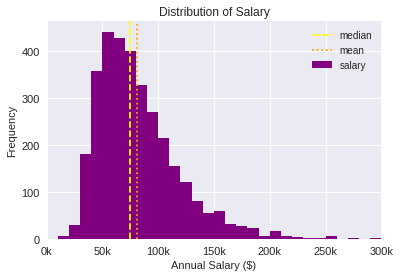

In [21]:
# plot histogram of salary distribution
df.salary.plot(kind='hist', bins=range(10000, 300001, 10000), 
               title='Distribution of Salary',
               fontsize=11, color='purple')
plt.xlabel('Annual Salary ($)')
plt.xlim(0,300000)
plt.xticks(range(0, 300001, 50000), ['0k', '50k', '100k', '150k', '200k', '250k', '300k'])
# add median and mean lines
plt.axvline(np.median(df.salary), linestyle='dashed', c='yellow', label='median')
plt.axvline(np.mean(df.salary), linestyle='dotted', c='orange', label='mean')
plt.legend(loc='best')

In [22]:
df['high_salary'] = df.salary > salary_median
eda(df)

Head of the dataframe:

                         company  \
0        Quintrix Solutions, Inc   
1  DEPT OF HEALTH/MENTAL HYGIENE   
2                   Blair Search   
3          Intellipro Group Inc.   
4                   Blair Search   

                                                                                                                                             description  \
0                      ESSENTIAL DUTIES AND RESPONSIBILITIES OF THE DATA SCIENTIST:. The starting salary for the Data Scientist position is $135,000....   
1  Maintain confidentiality of identifiable data. Supervise at least one City Research Scientist analyzing data, preparing manuscripts and presentati...   
2  Strong understanding of algorithms and advanced data structures. Experience in solutions that leverage distributed processing of large data sets (...   
3                         Work with data engineers and other stakeholders in data products pipeline to enable automation of the data-dr

In [23]:
# use state as the location
X = pd.get_dummies(df.state).drop('FL', axis=1) # use FL as the baseline since it has the most observations
y = df.high_salary

clf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42)
clf.fit(X, y)

# score of the training dataset obtained using an out-of-bag estimate
print(clf.oob_score_)

0.623384615385


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the job titles.
- Build a new random forest model with location and these new features included.

In [24]:
# streamline the process with a function
def random_forest_with_new_features(X, y, new_features, **kwargs):
    # build a Random Forest with X, y
    clf_before = RandomForestClassifier(n_estimators=1000, 
                                        oob_score=True, 
                                        n_jobs=-1, 
                                        random_state=42,
                                        **kwargs)
    clf_before.fit(X, y)
    
    # add new features (represented by a boolean whether a word is in the title)
    for feat in new_features:
        df_feat = df.title.str.lower().str.contains(feat)
        X = pd.concat((X, df_feat), axis=1)
        
    # build a new Random Forest with the new X and y
    clf_after = RandomForestClassifier(n_estimators=1000,
                                       oob_score=True,
                                       n_jobs=-1,
                                       random_state=42,
                                       **kwargs)
    clf_after.fit(X, y)
    
    # compare the scores before and after adding the new features
    score_change = clf_after.oob_score_ - clf_before.oob_score_
    print_out = 'The new features {} added value.\nChange in oob_score: {:.4f}'.format(new_features, score_change)
    if score_change <= 0:
        print_out = print_out.replace('added', 'did not add')
    print(print_out)
    return clf_before.oob_score_, clf_after.oob_score_

In [25]:
random_forest_with_new_features(X, y, ['manager', 'senior'])

The new features ['manager', 'senior'] added value.
Change in oob_score: 0.0265


(0.62338461538461543, 0.64984615384615385)

In [26]:
random_forest_with_new_features(X, y, ['manager', 'senior', 'data scientist', 'research', 'analyst'])

The new features ['manager', 'senior', 'data scientist', 'research', 'analyst'] added value.
Change in oob_score: 0.0274


(0.62338461538461543, 0.65076923076923077)

##### Use countervectorizer to generate features

In [27]:
cvec = CountVectorizer(min_df=10, max_features=150, binary=True, 
                       stop_words=stopwords.words('english'))
title_features = cvec.fit_transform(df.title)

# which text features are extracted from title
cvec.get_feature_names()

['2017',
 'academic',
 'accounting',
 'administrator',
 'analysis',
 'analyst',
 'analytics',
 'application',
 'applications',
 'architect',
 'assessment',
 'assistant',
 'associate',
 'assurance',
 'automation',
 'az',
 'bi',
 'big',
 'budget',
 'bureau',
 'business',
 'care',
 'center',
 'chief',
 'civil',
 'clearance',
 'clinical',
 'compliance',
 'computer',
 'consultant',
 'control',
 'controls',
 'coordinator',
 'credit',
 'customer',
 'data',
 'database',
 'design',
 'developer',
 'development',
 'devops',
 'director',
 'education',
 'electrical',
 'end',
 'engineer',
 'engineering',
 'enterprise',
 'entry',
 'environmental',
 'executive',
 'fellow',
 'field',
 'financial',
 'full',
 'general',
 'gis',
 'gs',
 'health',
 'healthcare',
 'human',
 'ii',
 'iii',
 'information',
 'infrastructure',
 'institute',
 'institutional',
 'integration',
 'intelligence',
 'interdisciplinary',
 'iv',
 'java',
 'jr',
 'junior',
 'laboratory',
 'lead',
 'learning',
 'level',
 'machine',
 'manage

In [28]:
# use text features in titles only because adding location info does not improve accuracy
title_df = pd.DataFrame(title_features.toarray(), columns=cvec.get_feature_names())

clf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42)
clf.fit(title_df, y)

# score of the training dataset obtained using an out-of-bag estimate
print(clf.oob_score_)

0.748307692308


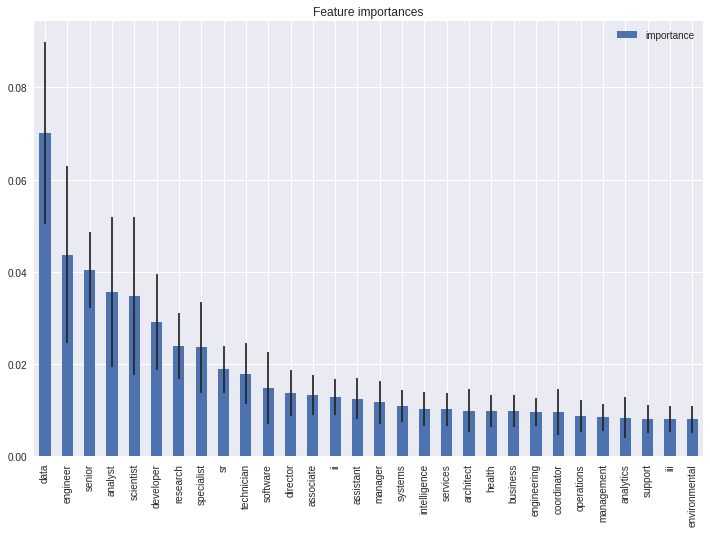

In [29]:
importances = clf.feature_importances_

# calculate the standard deviation of feature importances by looping over the trees in the random forest
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

importances_df = pd.DataFrame({'importance': importances, 'std': std}, 
                              index=title_df.columns).sort_values(
    by='importance', ascending=False)
   
# Plot the feature importances of the forest
importances_df.head(30).plot(kind='bar', y='importance', rot=90, 
                             figsize=(12,8), title='Feature importances', 
                             sort_columns=False, align="center", yerr='std');

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [30]:
%%time
scores = cross_val_score(clf, title_df, y, scoring='accuracy', cv=10)
print('Accuracy score for random forest is {:.4f} +/- {:.4f}'.format(np.mean(scores), np.std(scores)))

Accuracy score for random forest is 0.7186 +/- 0.0594
CPU times: user 53.9 s, sys: 844 ms, total: 54.7 s
Wall time: 25.5 s


#### Repeat the model-building process with a non-tree-based method.

##### Logistic Regression

In [31]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, title_df, y, cv=10, scoring='accuracy')
print('Accuracy score for logistic regression is {:.4f} +/- {:.4f}'.format(np.mean(scores), np.std(np.std(scores))))

Accuracy score for logistic regression is 0.7274 +/- 0.0000


In [32]:
# take a closer look at the coefficients
logreg.fit(title_df, y)
coef = pd.Series(logreg.coef_[0], index=title_df.columns).sort_values()

# negative coefficients
coef.head(10)

technician     -2.785243
field          -1.661662
teacher        -1.635070
student        -1.590912
training       -1.255084
postdoctoral   -1.228058
coordinator    -1.188512
academic       -1.149895
jr             -1.126933
phoenix        -1.040012
dtype: float64

In [33]:
# positive coefficients
coef.tail(10)

developer         1.418654
chief             1.446529
infrastructure    1.454259
machine           1.490738
senior            1.519119
director          1.529661
intelligence      1.531070
principal         1.618392
architect         1.708831
quantitative      2.169950
dtype: float64

In [34]:
# match the coeffients with the important keywords identified by Random Forest
coef[importances_df.head(20).index]

data            1.131870
engineer        1.044775
senior          1.519119
analyst        -0.540957
scientist       1.108205
developer       1.418654
research       -0.519358
specialist     -0.923351
sr              1.251891
technician     -2.785243
software        0.575291
director        1.529661
associate      -0.996501
ii             -0.623199
assistant      -1.009295
manager         0.729317
systems         0.609532
intelligence    1.531070
services       -0.959313
architect       1.708831
dtype: float64

In [35]:
# combine the keyword importances and coefficients for visualization
importances_df['impact_coef'] = coef[importances_df.index]

def direction(coef):
    if coef > 0:
        return 'positive'
    elif coef < 0:
        return 'negative'
    else:
        return 'neutral'
    
    
importances_df['impact_direction'] = importances_df.impact_coef.apply(direction)
importances_df.index.name='keyword'
importances_df.to_csv('importance.csv')

See the code for word cloud visualization [here](word_cloud.ipynb).

##### KNN

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, title_df, y, cv=10, scoring='accuracy')
print('Accuracy score for KNN is {:.4f} +/- {:.4f}'.format(np.mean(scores), np.std(np.std(scores))))

Accuracy score for KNN is 0.6650 +/- 0.0000


##### SVM

In [37]:
%%time
clf = SVC()
C_range = 10.**np.arange(-2, 3)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
param_grid = dict(C=C_range, kernel=kernel_range)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', n_jobs=5)
grid.fit(title_df, y)

CPU times: user 3.18 s, sys: 60 ms, total: 3.24 s
Wall time: 3min 1s


In [38]:
# best parameters
grid.best_params_

{'C': 100.0, 'kernel': 'rbf'}

In [39]:
# best score
grid.best_score_

0.73138461538461541

In [40]:
def do_cv(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print('Model: {}\n'.format(model))
    mean = np.mean(scores)
    std = np.std(scores)
    print('The mean of the cross validation scores is {:.4f}; the standard deviation is {:.4f}'.format(mean, std))
    return mean, std


do_cv(grid.best_estimator_, title_df, y, 10)

Model: SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The mean of the cross validation scores is 0.7314; the standard deviation is 0.0626


(0.73142467620995233, 0.06264323612074936)

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the job descriptions. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [41]:
# extract text features from the titles
cvec_title = CountVectorizer(min_df=10,
                             max_features=150, binary=True,
                             stop_words=stopwords.words('english'))
title_features = cvec_title.fit_transform(df.title)
title_df = pd.DataFrame(title_features.toarray(), columns=cvec_title.get_feature_names())

# extract text features from the job description snippets
stop_words_desc = set(stopwords.words('english')) | set(cvec_title.get_feature_names())
cvec_desc = CountVectorizer(min_df=10,
                            max_features=150, binary=True,
                            stop_words=stop_words_desc)
desc_features = cvec_desc.fit_transform(df.description)
desc_df = pd.DataFrame(desc_features.toarray(), columns=cvec_desc.get_feature_names())

# combine the features
combined_df = pd.concat((X, title_df, desc_df), axis=1)

clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
clf.fit(combined_df, y)

scores = cross_val_score(clf, combined_df, y, scoring='accuracy', cv=10)
print('Accuracy score for random forest is {:.4f} +/- {:.4f}'.format(np.mean(scores), np.std(scores)))

Accuracy score for random forest is 0.7020 +/- 0.0710


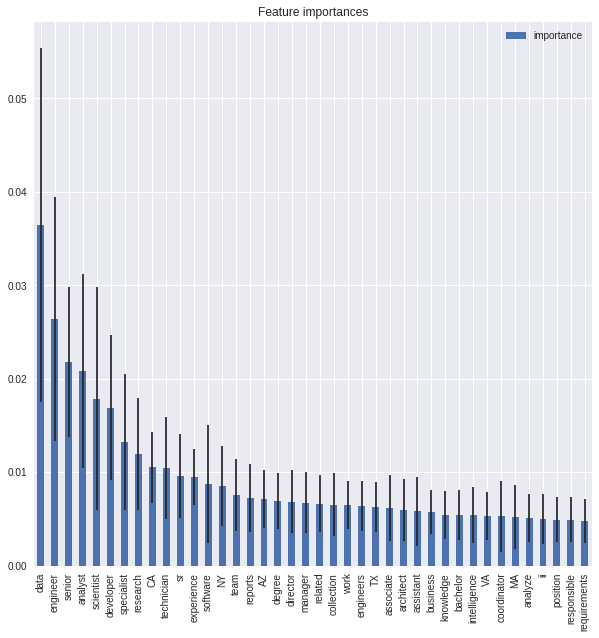

In [42]:
importances = clf.feature_importances_

# calculate the standard deviation of feature importances by looping over the trees in the random forest
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

importances_df = pd.DataFrame({'importance': importances, 'std': std}, 
                              index=combined_df.columns).sort_values(
    by='importance', ascending=False)

# Plot the feature importances of the forest
importances_df.head(40).plot(kind='bar', y='importance', rot=90, 
                             figsize=(10,10), title='Feature importances', 
                             sort_columns=False, align="center", yerr='std');

### Executive summary can be found on [Google Docs](https://docs.google.com/document/d/13Ujc-SzP7ir9S4elRIywPP050nFRyVhusjUOmTWo-EA/edit?usp=sharing).